In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
import random
from IPython.display import display, HTML

In [2]:
import wandb
wandb.login(key="8b9afebd4705d9e357dd7b2fa957f97e19705bf1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roohmr1011 (roohiparveen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# ---------------------------
# Vocab Utilities
# ---------------------------
def build_vocab_from_data(path, column=0):
    counter = Counter()
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            text = parts[column]
            counter.update(list(text))
    chars = sorted(counter.keys())
    vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
    for i, char in enumerate(chars, start=4):
        vocab[char] = i
    return vocab

def inverse_vocab(vocab):
    return {idx: char for char, idx in vocab.items()}

# ---------------------------
# Dataset & Collate
# ---------------------------
class TransliterationDataset(Dataset):
    def __init__(self, path, input_vocab, output_vocab):
        self.data = []
        with open(path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    continue
                tgt, src = parts[0], parts[1]
                src_ids = [input_vocab['<sos>']] + [input_vocab.get(c, input_vocab['<unk>']) for c in src] + [input_vocab['<eos>']]
                tgt_ids = [output_vocab['<sos>']] + [output_vocab.get(c, output_vocab['<unk>']) for c in tgt] + [output_vocab['<eos>']]
                self.data.append((src_ids, tgt_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def pad_collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    max_src_len = max(len(seq) for seq in src_batch)
    max_tgt_len = max(len(seq) for seq in tgt_batch)
    padded_src = [seq + [input_vocab['<pad>']] * (max_src_len - len(seq)) for seq in src_batch]
    padded_tgt = [seq + [output_vocab['<pad>']] * (max_tgt_len - len(seq)) for seq in tgt_batch]
    return torch.tensor(padded_src), torch.tensor(padded_tgt)
# ---------------------------
# Setup Paths and Build Vocab
# ---------------------------
data_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons"
train_file = os.path.join(data_path, "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv")
dev_file = os.path.join(data_path, "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv")

input_vocab = build_vocab_from_data(train_file, column=1)   # Latin script
output_vocab = build_vocab_from_data(train_file, column=0)  # Native script

inv_input_vocab = inverse_vocab(input_vocab)
inv_output_vocab = inverse_vocab(output_vocab)

PAD_IDX = output_vocab['<pad>']

# ---------------------------
# Create Datasets and Loaders
# ---------------------------
train_dataset = TransliterationDataset(train_file, input_vocab, output_vocab)
val_dataset = TransliterationDataset(dev_file, input_vocab, output_vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate_fn)

# ---------------------------
# Attention Model
# ---------------------------
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        src_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden[-1]  # outputs: [batch, src_len, hidden], hidden: [batch, hidden]

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.rnn = nn.GRU(enc_hidden_dim + emb_dim, dec_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        embedded = embedded.squeeze(1)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

# ---------------------------
# Training with W&B Sweep
# ---------------------------
def sweep_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        attention = Attention(config.hidden_dim, config.hidden_dim)
        encoder = Encoder(len(input_vocab), config.embedding_dim, config.hidden_dim, config.num_layers, config.dropout)
        decoder = Decoder(len(output_vocab), config.embedding_dim, config.hidden_dim, config.hidden_dim, attention, config.dropout)
        model = Seq2Seq(encoder, decoder).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=output_vocab['<pad>'])

        best_val_loss = float('inf')

        for epoch in range(10):
            model.train()
            total_loss, total_correct, total_tokens = 0, 0, 0
            for src, trg in train_loader:
                src, trg = src.to(device), trg.to(device)
                optimizer.zero_grad()
                output = model(src, trg, config.teacher_forcing_ratio)
                output = output[:, 1:].reshape(-1, output.shape[-1])
                trg = trg[:, 1:].reshape(-1)
                loss = criterion(output, trg)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                total_correct += (output.argmax(1) == trg).sum().item()
                total_tokens += trg.ne(output_vocab['<pad>']).sum().item()

            train_loss = total_loss / len(train_loader)
            train_acc = total_correct / total_tokens

            model.eval()
            val_loss, val_correct, val_tokens = 0, 0, 0
            with torch.no_grad():
                for src, trg in val_loader:
                    src, trg = src.to(device), trg.to(device)
                    output = model(src, trg, 0)
                    output = output[:, 1:].reshape(-1, output.shape[-1])
                    trg = trg[:, 1:].reshape(-1)
                    loss = criterion(output, trg)
                    val_loss += loss.item()
                    val_correct += (output.argmax(1) == trg).sum().item()
                    val_tokens += trg.ne(output_vocab['<pad>']).sum().item()

            val_loss /= len(val_loader)
            val_acc = val_correct / val_tokens

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "embedding_dim": config.embedding_dim,
                "hidden_dim": config.hidden_dim,
                "num_layers": config.num_layers,
                "dropout": config.dropout,
                "teacher_forcing_ratio": config.teacher_forcing_ratio
            })

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_attention_model.pt")

# ---------------------------
# W&B Sweep Config
# ---------------------------
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "embedding_dim": {"values": [32, 64]},
        "hidden_dim": {"values": [64, 128]},
        "num_layers": {"values": [1]},
        "dropout": {"values": [0.2, 0.3]},
        "learning_rate": {"values": [0.001]},
        "teacher_forcing_ratio": {"values": [0.5]}
    }
}

In [7]:
# ---------------------------
# Vocab Utilities
# ---------------------------
def build_vocab_from_data(path, column=0):
    counter = Counter()
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            text = parts[column]
            counter.update(list(text))
    chars = sorted(counter.keys())
    vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
    for i, char in enumerate(chars, start=4):
        vocab[char] = i
    return vocab

def inverse_vocab(vocab):
    return {idx: char for char, idx in vocab.items()}

# ---------------------------
# Dataset & Collate
# ---------------------------
class TransliterationDataset(Dataset):
    def __init__(self, path, input_vocab, output_vocab):
        self.data = []
        with open(path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    continue
                tgt, src = parts[0], parts[1]
                src_ids = [input_vocab['<sos>']] + [input_vocab.get(c, input_vocab['<unk>']) for c in src] + [input_vocab['<eos>']]
                tgt_ids = [output_vocab['<sos>']] + [output_vocab.get(c, output_vocab['<unk>']) for c in tgt] + [output_vocab['<eos>']]
                self.data.append((src_ids, tgt_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def pad_collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    max_src_len = max(len(seq) for seq in src_batch)
    max_tgt_len = max(len(seq) for seq in tgt_batch)
    padded_src = [seq + [input_vocab['<pad>']] * (max_src_len - len(seq)) for seq in src_batch]
    padded_tgt = [seq + [output_vocab['<pad>']] * (max_tgt_len - len(seq)) for seq in tgt_batch]
    return torch.tensor(padded_src), torch.tensor(padded_tgt)
# ---------------------------
# Setup Paths and Build Vocab
# ---------------------------
data_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons"
train_file = os.path.join(data_path, "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv")
dev_file = os.path.join(data_path, "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv")

input_vocab = build_vocab_from_data(train_file, column=1)   # Latin script
output_vocab = build_vocab_from_data(train_file, column=0)  # Native script

inv_input_vocab = inverse_vocab(input_vocab)
inv_output_vocab = inverse_vocab(output_vocab)

PAD_IDX = output_vocab['<pad>']

# ---------------------------
# Create Datasets and Loaders
# ---------------------------
train_dataset = TransliterationDataset(train_file, input_vocab, output_vocab)
val_dataset = TransliterationDataset(dev_file, input_vocab, output_vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate_fn)

# ---------------------------
# Attention Model
# ---------------------------
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        src_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, src):
        embedded = self.embedding_dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden[-1]

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding_dropout = nn.Dropout(dropout)
        self.attention = attention
        self.rnn = nn.GRU(enc_hidden_dim + emb_dim, dec_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding_dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        embedded = embedded.squeeze(1)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

# ---------------------------
# Training with W&B Sweep
# ---------------------------
def sweep_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        attention = Attention(config.hidden_dim, config.hidden_dim)
        encoder = Encoder(len(input_vocab), config.embedding_dim, config.hidden_dim, config.num_layers, config.dropout)
        decoder = Decoder(len(output_vocab), config.embedding_dim, config.hidden_dim, config.hidden_dim, attention, config.dropout)
        model = Seq2Seq(encoder, decoder).to(device)

        wandb.watch(model, log='all', log_freq=100)

        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


        best_val_loss = float('inf')
        patience = 3
        epochs_no_improve = 0

        for epoch in range(10):
            teacher_forcing_ratio = config.teacher_forcing_ratio * (0.95 ** epoch)
            model.train()
            total_loss, total_correct, total_tokens = 0, 0, 0
            for src, trg in train_loader:
                src, trg = src.to(device), trg.to(device)
                optimizer.zero_grad()
                output = model(src, trg, teacher_forcing_ratio)
                output = output[:, 1:].reshape(-1, output.shape[-1])
                trg = trg[:, 1:].reshape(-1)
                loss = criterion(output, trg)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
                total_correct += (output.argmax(1) == trg).sum().item()
                total_tokens += trg.ne(PAD_IDX).sum().item()

            train_loss = total_loss / len(train_loader)
            train_acc = total_correct / total_tokens

            model.eval()
            val_loss, val_correct, val_tokens = 0, 0, 0
            with torch.no_grad():
                for src, trg in val_loader:
                    src, trg = src.to(device), trg.to(device)
                    output = model(src, trg, 0)
                    output = output[:, 1:].reshape(-1, output.shape[-1])
                    trg = trg[:, 1:].reshape(-1)
                    loss = criterion(output, trg)
                    val_loss += loss.item()
                    val_correct += (output.argmax(1) == trg).sum().item()
                    val_tokens += trg.ne(PAD_IDX).sum().item()

            val_loss /= len(val_loader)
            val_acc = val_correct / val_tokens

            scheduler.step(val_loss)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "lr": scheduler.optimizer.param_groups[0]['lr'],
                "teacher_forcing_ratio": teacher_forcing_ratio
            })

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_attention_model.pt")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    break

# ---------------------------
# W&B Sweep Config
# ---------------------------
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "embedding_dim": {"values": [32, 64]},
        "hidden_dim": {"values": [64, 128]},
        "num_layers": {"values": [1]},
        "dropout": {"values": [0.2, 0.3]},
        "learning_rate": {"values": [0.001]},
        "teacher_forcing_ratio": {"values": [0.5]}
    }
}

In [5]:
import torch.optim as optim


In [8]:
sweep_id = wandb.sweep(sweep_config, project="DA6401 Assignment 3")
wandb.agent(sweep_id, function=sweep_train, count=20)

Create sweep with ID: vdneipdr
Sweep URL: https://wandb.ai/roohiparveen/DA6401%20ASSIGNMENT%203/sweeps/vdneipdr


wandb: Agent Starting Run: 888zyp02 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇███████
train_loss,█▂▂▁▁▁▁▁▁▁
val_acc,▁▆▆▇▇█▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.89331


wandb: Agent Starting Run: koqm79s6 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████████▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▅▇▇█████▇
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.92248


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9rzc1qz with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▆▇█▇▇▇█
val_loss,█▄▃▂▂▁▁▂▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.91757


wandb: Agent Starting Run: qwvx560w with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


Early stopping triggered.


epoch,▁▂▃▄▅▅▆▇█
lr,████▃▃▃▁▁
teacher_forcing_ratio,█▇▆▅▄▃▂▂▁
train_acc,▁▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁
val_acc,▁▅▇▆▆███▇
val_loss,█▄▂▃▂▁▁▁▂
epoch,9
lr,0.00025
teacher_forcing_ratio,0.33171
train_acc,0.92543


wandb: Agent Starting Run: rsvqbtr3 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇██▇
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.88713


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lmpcectf with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,██████▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▆▇▆▇▇██
val_loss,█▅▄▄▂▃▂▂▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.92102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 028ajjm0 with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▄▆▆▆▇▇▇▇█
val_loss,█▇▄▄▄▃▃▂▂▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.88808


wandb: Agent Starting Run: w2wd7210 with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,███████▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇██
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.89191


wandb: Agent Starting Run: 1oybcmnj with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇███████
train_loss,█▂▂▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇████
val_loss,█▅▄▄▃▃▂▂▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.88893


wandb: Agent Starting Run: jdxa2osq with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▅▃▄▃▂▂▂▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.88732


wandb: Agent Starting Run: t1gsooee with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


Early stopping triggered.


epoch,▁▂▄▅▇█
lr,████▁▁
teacher_forcing_ratio,█▆▅▄▂▁
train_acc,▁▇▇███
train_loss,█▂▂▂▁▁
val_acc,▁▆██▇█
val_loss,█▃▁▁▂▁
epoch,6
lr,0.0005
teacher_forcing_ratio,0.38689
train_acc,0.90698


wandb: Agent Starting Run: qxqru1lc with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████▃▃▃▃▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▅▇▇▇████
val_loss,█▄▄▂▂▃▁▁▁▁
epoch,10
lr,0.00025
teacher_forcing_ratio,0.31512
train_acc,0.91915


wandb: Agent Starting Run: 4f079xna with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████████▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▇▇█▇██▇
val_loss,█▆▃▂▃▂▁▁▁▂
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.91689


wandb: Agent Starting Run: rq2cco6n with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████████▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▅▆▇▇██▇█
val_loss,█▄▄▃▃▂▂▁▂▂
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.91702


wandb: Agent Starting Run: sum4agwb with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,███████▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▅▅▆▇█▆▇██
val_loss,█▄▅▄▁▁▃▂▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.92204


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9kssojiq with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,███████▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇██▇██
val_loss,█▄▄▂▃▁▂▃▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.92193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e1g6db5f with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▃▂▂▁▂▁▂
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.90869


wandb: Agent Starting Run: nuxzghay with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▃▆▇█▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.90833


wandb: Agent Starting Run: ucm84k2k with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████████▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▄▃▂▃▂▁▁▁▁
epoch,10
lr,0.0005
teacher_forcing_ratio,0.31512
train_acc,0.90748


wandb: Agent Starting Run: namz22xq with config:
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▁▁▁▁▁▁▁▁▁
teacher_forcing_ratio,█▇▆▅▄▄▃▂▂▁
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
lr,0.001
teacher_forcing_ratio,0.31512
train_acc,0.90983


In [11]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter, namedtuple
import pandas as pd
import random
from IPython.display import HTML, display
import heapq

# ---------------------------
# Vocab Utilities
# ---------------------------
def build_vocab_from_data(path, column=0):
    counter = Counter()
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            text = parts[column]
            counter.update(list(text))
    chars = sorted(counter.keys())
    vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
    for i, char in enumerate(chars, start=4):
        vocab[char] = i
    return vocab

def inverse_vocab(vocab):
    return {idx: char for char, idx in vocab.items()}

# ---------------------------
# Dataset
# ---------------------------
class TestDataset(Dataset):
    def __init__(self, path, input_vocab):
        self.data = []
        self.words = []
        with open(path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 2:
                    continue
                tgt, src = parts[0], parts[1]
                self.words.append((src, tgt))
                src_ids = [input_vocab['<sos>']] + [input_vocab.get(c, input_vocab['<unk>']) for c in src] + [input_vocab['<eos>']]
                self.data.append((src_ids, tgt))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# ---------------------------
# Model Definitions
# ---------------------------
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        src_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden[-1]

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, attention, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.rnn = nn.GRU(enc_hidden_dim + emb_dim, dec_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        embedded = embedded.squeeze(1)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

# ---------------------------
# Beam Search Decoding
# ---------------------------
Hypothesis = namedtuple('Hypothesis', ['tokens', 'log_prob', 'hidden'])

def beam_search_decode(model, src_tensor, output_vocab, inv_output_vocab, beam_width=5, max_len=30):
    model.eval()
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

        start_token = output_vocab['<sos>']
        end_token = output_vocab['<eos>']
        beam = [Hypothesis(tokens=[start_token], log_prob=0.0, hidden=hidden)]

        completed_hypotheses = []

        for _ in range(max_len):
            new_beam = []
            for hyp in beam:
                input_token = torch.tensor([hyp.tokens[-1]]).to(src_tensor.device)
                output, new_hidden = model.decoder(input_token, hyp.hidden, encoder_outputs)
                log_probs = torch.log_softmax(output, dim=1).squeeze(0)

                top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                for log_prob, idx in zip(top_log_probs.tolist(), top_indices.tolist()):
                    new_tokens = hyp.tokens + [idx]
                    new_log_prob = hyp.log_prob + log_prob
                    new_hyp = Hypothesis(tokens=new_tokens, log_prob=new_log_prob, hidden=new_hidden)

                    if idx == end_token:
                        completed_hypotheses.append(new_hyp)
                    else:
                        new_beam.append(new_hyp)

            beam = heapq.nlargest(beam_width, new_beam, key=lambda h: h.log_prob)

            if len(beam) == 0:
                break

        best_hyp = max(completed_hypotheses, key=lambda h: h.log_prob) if completed_hypotheses else beam[0]
        pred_ids = best_hyp.tokens[1:]
        if end_token in pred_ids:
            pred_ids = pred_ids[:pred_ids.index(end_token)]

        pred_word = ''.join([inv_output_vocab[i] for i in pred_ids])
        return pred_word

# ---------------------------
# Paths and Vocab building
# ---------------------------
data_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/ta/lexicons"
train_file = os.path.join(data_path, "ta.translit.sampled.train.tsv")
test_file = os.path.join(data_path, "ta.translit.sampled.test.tsv")

input_vocab = build_vocab_from_data(train_file, column=1)
output_vocab = build_vocab_from_data(train_file, column=0)
inv_output_vocab = inverse_vocab(output_vocab)

# ---------------------------
# Create Test Dataset
# ---------------------------
test_dataset = TestDataset(test_file, input_vocab)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ---------------------------
# Load best model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim = 32
hidden_dim = 128
num_layers = 1
dropout = 0.3


attention = Attention(hidden_dim, hidden_dim)
encoder = Encoder(len(input_vocab), embedding_dim, hidden_dim, num_layers, dropout)
decoder = Decoder(len(output_vocab), embedding_dim, hidden_dim, hidden_dim, attention, dropout)
model = Seq2Seq(encoder, decoder).to(device)

model.load_state_dict(torch.load("best_attention_model.pt", map_location=device))
model.eval()

# ---------------------------
# Predict with Beam Search
# ---------------------------
predictions = []
correct_preds = []
beam_width = 5

with torch.no_grad():
    for i, (src_ids, tgt_word) in enumerate(test_dataset):
        src_tensor = torch.tensor([src_ids]).to(device)
        pred_word = beam_search_decode(model, src_tensor, output_vocab, inv_output_vocab, beam_width=beam_width)

        src_word = test_dataset.words[i][0]
        predictions.append((tgt_word, src_word, pred_word))

        if pred_word == tgt_word:
            correct_preds.append((src_word, pred_word))

# Save predictions
os.makedirs("predictions_attn", exist_ok=True)
df = pd.DataFrame(predictions, columns=["target", "input", "predicted"])
df.to_csv("predictions_attn/test_predictions_attention.tsv", sep='\t', index=False)


In [12]:
# Display sample correct predictions
sample_correct = random.sample(correct_preds, min(10, len(correct_preds)))
html = "<table border='1' style='border-collapse: collapse;'><tr><th>Input</th><th>Predicted (Correct)</th></tr>"
for src, pred in sample_correct:
    html += f"<tr><td style='padding:5px;font-family:monospace'>{src}</td><td style='padding:5px;font-family:monospace'>{pred}</td></tr>"
html += "</table>"
display(HTML(html))

Input,Predicted (Correct)
pirkaalangkalil,பிற்காலங்களில்
valangkappaduvathu,வழங்கப்படுவது
matrtravarkalum,மற்றவர்களும்
naveenaththuvam,நவீனத்துவம்
thuvangappatta,துவங்கப்பட்ட
pulavargal,புலவர்கள்
kattamaikkappatta,கட்டமைக்கப்பட்ட
thalaimaiyidam,தலைமையிடம்
cheythavaruku,செய்தவருக்கு
earpaduthal,ஏற்படுதல்


In [13]:
# ---------------------------
# Evaluation: Test Accuracy and Loss
# ---------------------------
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab['<pad>'])

total_loss = 0
total_correct = 0
total_chars = 0
model.eval()

with torch.no_grad():
    for src_ids, tgt_word in test_dataset:
        src_tensor = torch.tensor([src_ids]).to(device)
        trg_ids = [output_vocab['<sos>']] + [output_vocab.get(c, output_vocab['<unk>']) for c in tgt_word] + [output_vocab['<eos>']]
        trg_tensor = torch.tensor([trg_ids]).to(device)

        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0.0)  # no teacher forcing
        output_dim = output.shape[-1]

        output = output[:, 1:].reshape(-1, output_dim)  # ignore <sos>
        trg = trg_tensor[:, 1:].reshape(-1)             # ignore <sos>

        loss = criterion(output, trg)
        total_loss += loss.item()

        pred_ids = output.argmax(1).tolist()
        true_ids = trg.tolist()

        for p, t in zip(pred_ids, true_ids):
            if t == output_vocab['<pad>']:
                continue
            if p == t:
                total_correct += 1
            total_chars += 1

# Final metrics
avg_loss = total_loss / len(test_dataset)
accuracy = total_correct / total_chars * 100

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy (char-level): {accuracy:.2f}%")


Test Loss: 3.2515
Test Accuracy (char-level): 48.66%


In [14]:
# ---------------------------
# Compute Exact Match Accuracy
# ---------------------------
exact_matches = 0
total_samples = len(test_dataset)

model.eval()
with torch.no_grad():
    for i, (src_ids, tgt_word) in enumerate(test_dataset):
        src_tensor = torch.tensor([src_ids]).to(device)
        encoder_outputs, hidden = model.encoder(src_tensor)

        input_token = torch.tensor([output_vocab['<sos>']]).to(device)
        generated_ids = []

        for _ in range(30):  # max generation length
            output, hidden = model.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            if top1 == output_vocab['<eos>']:
                break
            generated_ids.append(top1)
            input_token = torch.tensor([top1]).to(device)

        pred_word = ''.join([inv_output_vocab[i] for i in generated_ids])
        tgt_word = test_dataset.words[i][1]  # ground truth

        if pred_word == tgt_word:
            exact_matches += 1

exact_match_accuracy = exact_matches / total_samples * 100
print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")


Exact Match Accuracy: 18.33%


/tmp/ipykernel_35/1482324413.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  attn_matrix = torch.tensor(attention_weights[:len(output_chars)])  # shape: [tgt_len, src_len]
/tmp/ipykernel_35/1482324413.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_chars, rotation=90)
/tmp/ipykernel_35/1482324413.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_chars)
/tmp/ipykernel_35/1482324413.py:59: UserWarning: Glyph 2959 (\N{TAMIL LETTER EE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1482324413.py:59: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
/tmp/ipykernel_35/1482324413.py

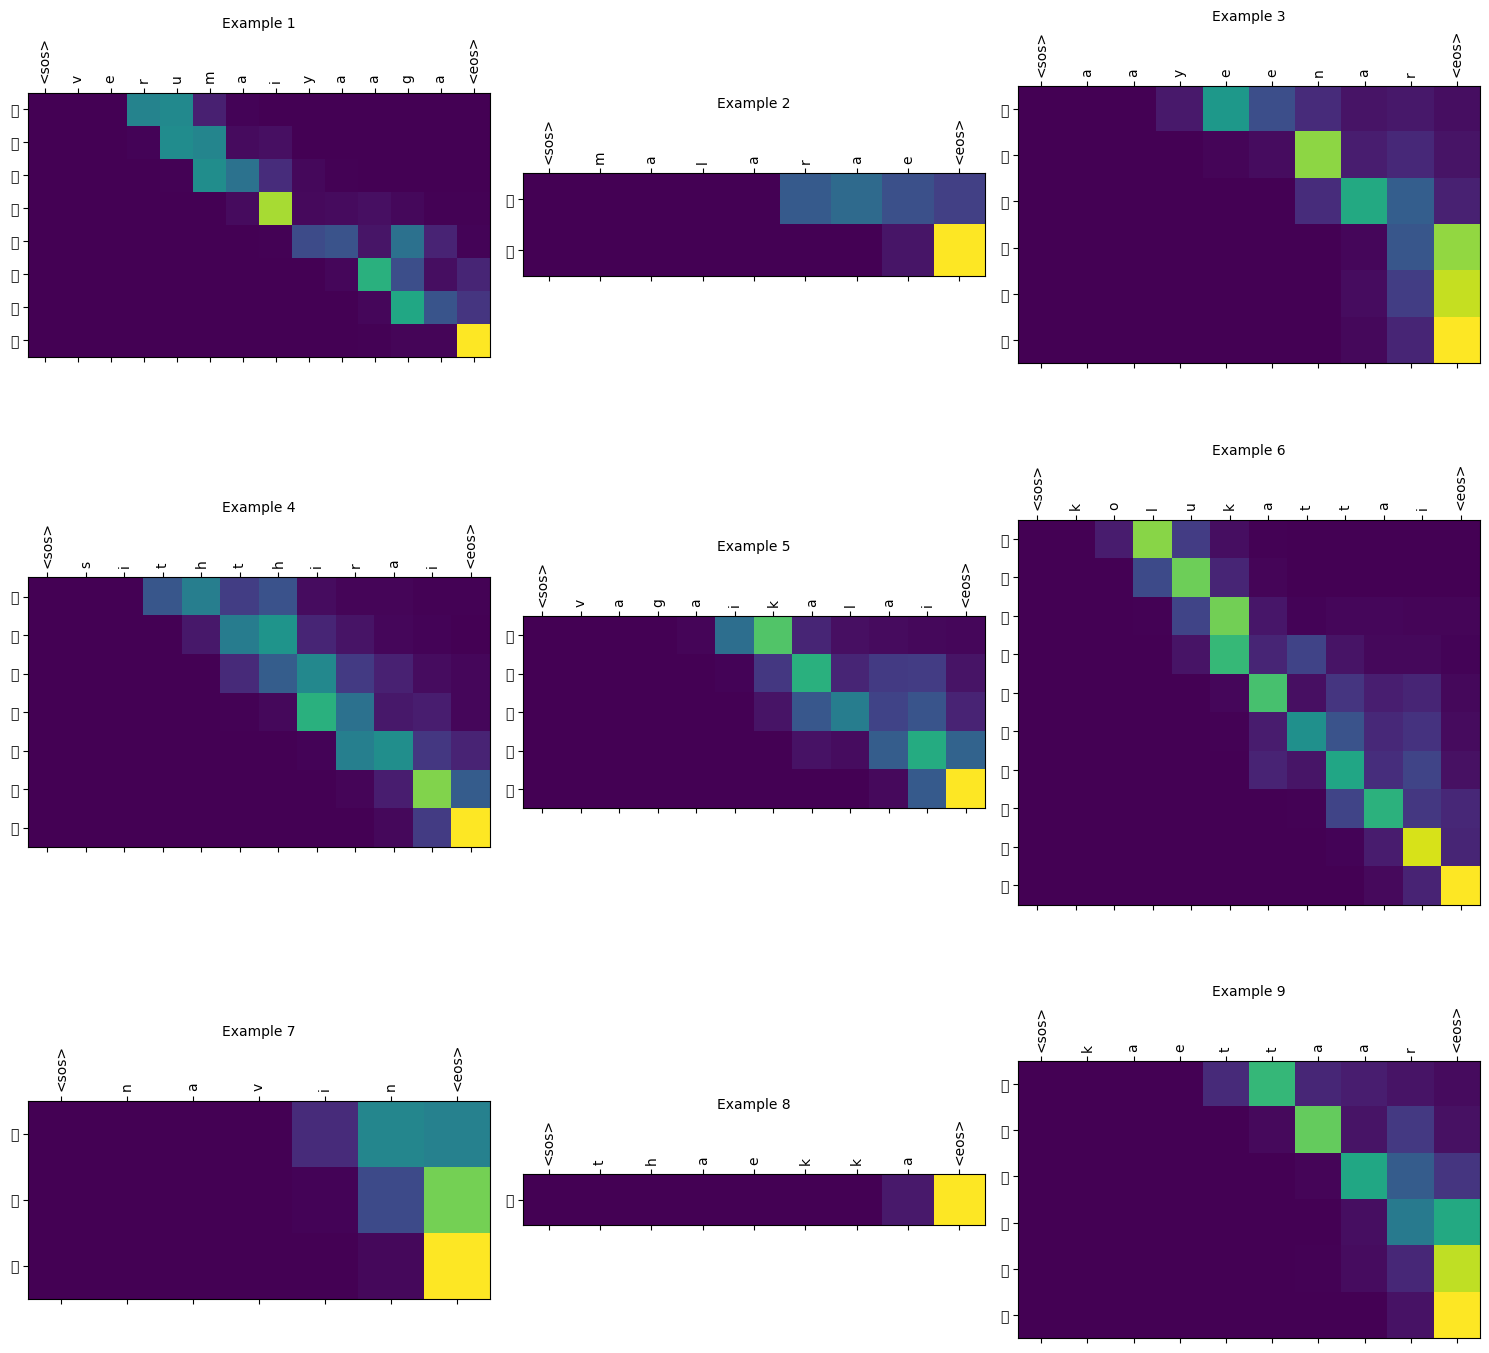

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import torch

# Ensure model is in eval mode
model.eval()

def get_attention_without_model_change(src_ids):
    src_tensor = torch.tensor([src_ids]).to(device)
    encoder_outputs, hidden = model.encoder(src_tensor)
    input_token = torch.tensor([output_vocab['<sos>']]).to(device)

    generated_ids = []
    attention_weights = []

    for _ in range(30):  # max output length
        output, hidden = model.decoder(input_token, hidden, encoder_outputs)

        # Recompute attention manually
        attn = model.decoder.attention(hidden, encoder_outputs)  # shape: [1, src_len]
        attention_weights.append(attn.squeeze(0).detach().cpu().numpy())  # ✅ FIXED LINE

        top1 = output.argmax(1).item()
        if top1 == output_vocab['<eos>']:
            break

        generated_ids.append(top1)
        input_token = torch.tensor([top1]).to(device)

    return generated_ids, attention_weights

# Plot a single heatmap
def plot_single_attention(src_ids, output_ids, attention_weights, ax, title=""):
    input_chars = [inv_input_vocab[i] for i in src_ids]
    output_chars = [inv_output_vocab[i] for i in output_ids]

    attn_matrix = torch.tensor(attention_weights[:len(output_chars)])  # shape: [tgt_len, src_len]

    cax = ax.matshow(attn_matrix.numpy(), cmap='viridis')
    ax.set_xticklabels([''] + input_chars, rotation=90)
    ax.set_yticklabels([''] + output_chars)
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Pick 9 random samples from test data
sample_indices = random.sample(range(len(test_dataset)), 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, sample_idx in enumerate(sample_indices):
    src_ids, tgt_word = test_dataset[sample_idx]
    output_ids, attn_weights = get_attention_without_model_change(src_ids)

    ax = axes[idx // 3, idx % 3]
    plot_single_attention(src_ids, output_ids, attn_weights, ax, title=f"Example {idx+1}")

plt.tight_layout()
plt.show()


/tmp/ipykernel_35/2885363866.py:19: UserWarning: Glyph 2990 (\N{TAMIL LETTER MA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/2885363866.py:19: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
/tmp/ipykernel_35/2885363866.py:19: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from current font.
  plt.tight_layout()


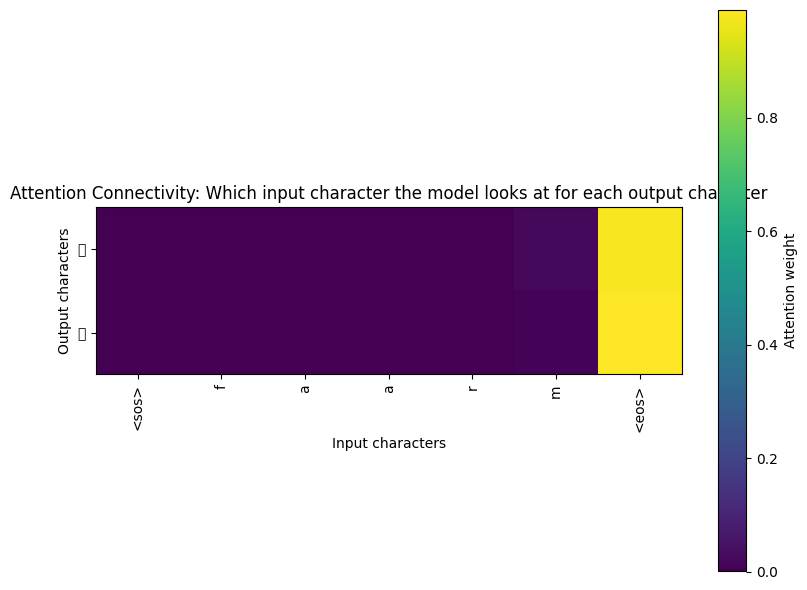

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_connectivity(src_ids, output_ids, attention_weights):
    input_chars = [inv_input_vocab[i] for i in src_ids]
    output_chars = [inv_output_vocab[i] for i in output_ids]

    attn_matrix = torch.tensor(attention_weights[:len(output_chars)])  # shape: [output_len, input_len]

    plt.figure(figsize=(8, 6))
    plt.imshow(attn_matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Attention weight')

    plt.xticks(ticks=range(len(input_chars)), labels=input_chars, rotation=90)
    plt.yticks(ticks=range(len(output_chars)), labels=output_chars)
    plt.xlabel("Input characters")
    plt.ylabel("Output characters")
    plt.title("Attention Connectivity: Which input character the model looks at for each output character")
    plt.tight_layout()
    plt.show()

# Example usage for a single test example
sample_idx = 0
src_ids, tgt_word = test_dataset[sample_idx]
output_ids, attn_weights = get_attention_without_model_change(src_ids)
plot_connectivity(src_ids, output_ids, attn_weights)
